In [4]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from PIL import Image
import requests
import os
import glob
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks

from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import Precision, Recall


# Optimizers
from tensorflow.keras.optimizers import Adam, Adamax

# Models
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionV3


In [5]:
from tensorflow.keras import models
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

In [7]:
train_data_dir = "../data_test/test_data/"
test_data_dir = "../data_test/train_data/"
batch_size = 4

#train_data_dir = "../data/Training"
#test_data_dir = "../data/Testing"

train_ds = image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size)

# We define a second one for the test data

val_ds = image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size)

Found 23 files belonging to 4 classes.
Found 90 files belonging to 4 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


## Version 1 - CNN simple

In [81]:
def initialize_model():

    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Dropout(0.2))

    model.add(Conv2D(64, (2, 2), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation = 'softmax'))

    return model

## Version simplifiée - model 2 - moins de layer

In [9]:
def initialize_CNN_simplified_model2():
    model = Sequential([
        Conv2D (64, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D((2,2)),

        Conv2D(32, kernel_size=(3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(31, kernel_size=(3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),

        Dense(64, activation='relu'),
        Dense(32, activation='relu'),

        Dense(4, activation='softmax')
    ])
    return model

## Version 2 - CNN plus complexe
NB -> certains ne mettent que 2 couches de 128,256,512
+ Adamax en optimizer
+ drop-out avant last Dense Layer

In [80]:
def initialize_CNN_model_complexe():
    model1 = Sequential()

    model1.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape=(224, 224, 3))),
    model1.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(MaxPooling2D((2, 2)))

    model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(MaxPooling2D((2, 2)))

    model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(MaxPooling2D((2, 2)))

    model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add( MaxPooling2D((2, 2)))

    model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(MaxPooling2D((2, 2)))

    model1.add(Flatten())

    model1.add(Dense(256,activation = "relu"))
    model1.add(Dense(64,activation = "relu"))
    model1.add(Dense(4, activation = "softmax"))

    return model1

## Version 3 - Xception

#### Pre-trained model loading: 
- include_top=False: Removes the original classification layers
- weights="imagenet": Loads weights pre-trained on ImageNet
- pooling='max': Uses max pooling to reduce spatial dimensions


#### Transfer learning setup:
- base_model.trainable = False freezes the weights of the pre-trained model, so they won't be updated during training.

In [49]:
def initialize_Xception_model():

    input_shape=(224, 224, 3)
    base_model = Xception(include_top= False, weights= "imagenet",
                                input_shape= input_shape, pooling= 'max')

    base_model.trainable = False

    inputs = Input(shape = input_shape)

    x = base_model(inputs)

    x = Flatten()(x)

    x = Dropout(rate= 0.3)(x)
    x = Dense(128, activation= 'relu')(x)
    x = Dropout(rate= 0.25)(x)
    x = Dense(4, activation= 'softmax')(x)

    model = Model(inputs, x)

    return model

## Version 4 - VGG19

In [59]:
def initialize_VGG19_model():
    base_model = VGG19(input_shape=(224,224,3), include_top=False, weights='imagenet')
    # Set all layers to non-trainable
    for layer in base_model.layers:
        layer.trainable = False
    # Set the last vgg block to trainable
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True

    model = Sequential()
    model.add(Input(shape=(224,224,3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    return model

## Version 5 - Inception 

In [ ]:
def initialize_inception_model():
    # build inception model
    base_model = InceptionV3(input_shape=(224,224,3), include_top=False, weights='imagenet')
    # Set all layers to non-trainable
    for layer in base_model.layers:
        layer.trainable = False
    # Set the last vgg block to trainable
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True
    base_model.layers[-5].trainable = True

    model = Sequential()
    model.add(Input(shape=(224,224,3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    return model

In [52]:
def compile_model1(model):
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = Adam(learning_rate = 0.01),
                  metrics = ['accuracy'])
    return model

In [11]:
def compile_model2(model):
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = Adamax(learning_rate = 0.01),
                  metrics = ['accuracy', Precision(), Recall()])
    return model

In [69]:
inception_model = initialize_inception_model()
inception_model = compile_model1(inception_model)

87910968/87910968 [==============================] - 9s 0us/step


In [65]:
vgg19_model = initialize_VGG19_model()
vgg19_model = compile_model1(vgg19_model)

80134624/80134624 [==============================] - 3s 0us/step


In [66]:
xception_model = initialize_Xception_model()
xception_model = compile_model1(xception_model)

83683744/83683744 [==============================] - 3s 0us/step


In [12]:
cnn_simplified_model = initialize_CNN_simplified_model2()
cnn_simplified_model = compile_model2(cnn_simplified_model)

In [82]:
cnn_simple_model = initialize_model()
cnn_simple_model = compile_model1(cnn_simple_model)

In [84]:
cnn_commplexe_model = initialize_CNN_model_complexe()
cnn_commplexe_model = compile_model1(cnn_commplexe_model)

In [86]:
%%time
es = EarlyStopping(monitor = 'val_loss',patience = 5, restore_best_weights=True, verbose = 2)
history_cnn_complexe = cnn_commplexe_model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds,
        callbacks = [es],
        verbose = 2)

Epoch 1/50
6/6 - 14s - loss: 11.0747 - accuracy: 0.2174 - val_loss: 4.1533 - val_accuracy: 0.2667 - 14s/epoch - 2s/step
Epoch 2/50
6/6 - 15s - loss: 2.4108 - accuracy: 0.2609 - val_loss: 2.0954 - val_accuracy: 0.2667 - 15s/epoch - 2s/step
Epoch 3/50
6/6 - 14s - loss: 1.6813 - accuracy: 0.1739 - val_loss: 1.4081 - val_accuracy: 0.2667 - 14s/epoch - 2s/step
Epoch 4/50
6/6 - 15s - loss: 1.4081 - accuracy: 0.2609 - val_loss: 1.4003 - val_accuracy: 0.2667 - 15s/epoch - 2s/step
Epoch 5/50
6/6 - 15s - loss: 1.3974 - accuracy: 0.2609 - val_loss: 1.3925 - val_accuracy: 0.2667 - 15s/epoch - 2s/step
Epoch 6/50
6/6 - 14s - loss: 1.3928 - accuracy: 0.2609 - val_loss: 1.3891 - val_accuracy: 0.2667 - 14s/epoch - 2s/step
Epoch 7/50
6/6 - 14s - loss: 1.3957 - accuracy: 0.2609 - val_loss: 1.3845 - val_accuracy: 0.2667 - 14s/epoch - 2s/step
Epoch 8/50
6/6 - 16s - loss: 1.3919 - accuracy: 0.2609 - val_loss: 1.3830 - val_accuracy: 0.2667 - 16s/epoch - 3s/step
Epoch 9/50
6/6 - 16s - loss: 1.3893 - accuracy:

KeyboardInterrupt: 

In [87]:
%%time
es = EarlyStopping(monitor = 'val_loss',patience = 10, restore_best_weights=True, verbose = 2)
history = cnn_simple_model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds,
        callbacks = [es],
        verbose = 2)

Epoch 1/50
6/6 - 0s - loss: 1.2361 - accuracy: 0.4348 - val_loss: 1.2689 - val_accuracy: 0.4667 - 440ms/epoch - 73ms/step
Epoch 2/50
6/6 - 0s - loss: 0.9602 - accuracy: 0.6087 - val_loss: 1.3248 - val_accuracy: 0.3889 - 394ms/epoch - 66ms/step
Epoch 3/50
6/6 - 0s - loss: 0.7320 - accuracy: 0.7826 - val_loss: 1.7873 - val_accuracy: 0.3889 - 404ms/epoch - 67ms/step
Epoch 4/50
6/6 - 0s - loss: 1.8681 - accuracy: 0.3913 - val_loss: 1.3577 - val_accuracy: 0.3111 - 407ms/epoch - 68ms/step
Epoch 5/50
6/6 - 0s - loss: 1.3724 - accuracy: 0.3043 - val_loss: 1.3758 - val_accuracy: 0.2778 - 387ms/epoch - 65ms/step
Epoch 6/50
6/6 - 0s - loss: 1.3896 - accuracy: 0.2174 - val_loss: 1.3871 - val_accuracy: 0.2667 - 381ms/epoch - 63ms/step
Epoch 7/50
6/6 - 0s - loss: 1.3171 - accuracy: 0.3478 - val_loss: 1.3884 - val_accuracy: 0.2556 - 383ms/epoch - 64ms/step
Epoch 8/50
6/6 - 0s - loss: 1.7050 - accuracy: 0.5217 - val_loss: 1.3875 - val_accuracy: 0.2667 - 401ms/epoch - 67ms/step
Epoch 9/50
6/6 - 0s - lo

In [88]:
%%time
es = EarlyStopping(monitor = 'val_loss',patience = 10, restore_best_weights=True, verbose = 2)
history_inception = inception_model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds,
        callbacks = [es],
        verbose = 2)

Epoch 1/50
6/6 - 2s - loss: 52.2723 - accuracy: 0.8261 - val_loss: 115.9233 - val_accuracy: 0.4000 - 2s/epoch - 386ms/step
Epoch 2/50
6/6 - 2s - loss: 46.2046 - accuracy: 0.8261 - val_loss: 143.2260 - val_accuracy: 0.4111 - 2s/epoch - 380ms/step
Epoch 3/50
6/6 - 2s - loss: 13.9983 - accuracy: 0.9130 - val_loss: 121.8091 - val_accuracy: 0.4333 - 2s/epoch - 402ms/step
Epoch 4/50
6/6 - 2s - loss: 20.5236 - accuracy: 0.6522 - val_loss: 58.0709 - val_accuracy: 0.4778 - 2s/epoch - 406ms/step
Epoch 5/50
6/6 - 2s - loss: 1.9118 - accuracy: 0.6522 - val_loss: 20.2103 - val_accuracy: 0.4778 - 2s/epoch - 399ms/step
Epoch 6/50
6/6 - 3s - loss: 0.3949 - accuracy: 0.6957 - val_loss: 8.6190 - val_accuracy: 0.4556 - 3s/epoch - 423ms/step
Epoch 7/50
6/6 - 3s - loss: 6.3528 - accuracy: 0.8261 - val_loss: 8.2673 - val_accuracy: 0.4556 - 3s/epoch - 420ms/step
Epoch 8/50
6/6 - 2s - loss: 0.5631 - accuracy: 0.7826 - val_loss: 8.5622 - val_accuracy: 0.4556 - 2s/epoch - 406ms/step
Epoch 9/50
6/6 - 3s - loss: 

In [89]:
%%time
es = EarlyStopping(monitor = 'val_loss',patience = 10, restore_best_weights=True, verbose = 2)
history_vgg19 = vgg19_model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds,
        callbacks = [es],
        verbose = 2)

Epoch 1/50
6/6 - 12s - loss: 1.3837 - accuracy: 0.2609 - val_loss: 1.3836 - val_accuracy: 0.2667 - 12s/epoch - 2s/step
Epoch 2/50
6/6 - 13s - loss: 1.3834 - accuracy: 0.2609 - val_loss: 1.3837 - val_accuracy: 0.2667 - 13s/epoch - 2s/step
Epoch 3/50
6/6 - 13s - loss: 1.3845 - accuracy: 0.2609 - val_loss: 1.3834 - val_accuracy: 0.2667 - 13s/epoch - 2s/step
Epoch 4/50
6/6 - 14s - loss: 1.3825 - accuracy: 0.2609 - val_loss: 1.3831 - val_accuracy: 0.2667 - 14s/epoch - 2s/step
Epoch 5/50
6/6 - 13s - loss: 1.3882 - accuracy: 0.2174 - val_loss: 1.3826 - val_accuracy: 0.2667 - 13s/epoch - 2s/step
Epoch 6/50
6/6 - 13s - loss: 1.3892 - accuracy: 0.2609 - val_loss: 1.3823 - val_accuracy: 0.2667 - 13s/epoch - 2s/step
Epoch 7/50
6/6 - 13s - loss: 1.3838 - accuracy: 0.2609 - val_loss: 1.3820 - val_accuracy: 0.2667 - 13s/epoch - 2s/step
Epoch 8/50


KeyboardInterrupt: 

In [90]:
%%time
es = EarlyStopping(monitor = 'val_loss',patience = 10, restore_best_weights=True, verbose = 2)
history_xception = xception_model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds,
        callbacks = [es],
        verbose = 2)

Epoch 1/50
6/6 - 4s - loss: 0.5596 - accuracy: 0.9565 - val_loss: 21.8905 - val_accuracy: 0.5667 - 4s/epoch - 662ms/step
Epoch 2/50
6/6 - 4s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 23.3979 - val_accuracy: 0.5667 - 4s/epoch - 697ms/step
Epoch 3/50
6/6 - 4s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 24.3010 - val_accuracy: 0.5667 - 4s/epoch - 675ms/step
Epoch 4/50
6/6 - 4s - loss: 7.5207e-04 - accuracy: 1.0000 - val_loss: 24.7633 - val_accuracy: 0.5667 - 4s/epoch - 708ms/step
Epoch 5/50
6/6 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 24.9173 - val_accuracy: 0.5667 - 4s/epoch - 732ms/step
Epoch 6/50
6/6 - 5s - loss: 1.4771e-06 - accuracy: 1.0000 - val_loss: 24.9831 - val_accuracy: 0.5667 - 5s/epoch - 774ms/step
Epoch 7/50
6/6 - 5s - loss: 2.4064e-04 - accuracy: 1.0000 - val_loss: 25.0078 - val_accuracy: 0.5667 - 5s/epoch - 835ms/step
Epoch 8/50
6/6 - 5s - loss: 4.8678e-04 - accuracy: 1.0000 - val_loss: 24.9860 - val_accuracy: 0.5667 - 5s/epoch - 827ms/step
Epoch 9/

In [13]:
%%time
es = EarlyStopping(monitor = 'val_loss',patience = 10, restore_best_weights=True, verbose = 2)
history_cnn_simple = cnn_simplified_model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds,
        callbacks = [es],
        verbose = 2)

Epoch 1/50


2025-03-12 12:05:51.988265: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 - 1s - loss: 1072.5132 - accuracy: 0.3043 - precision: 0.3043 - recall: 0.3043 - val_loss: 2.3362 - val_accuracy: 0.2222 - val_precision: 0.2182 - val_recall: 0.1333 - 1s/epoch - 183ms/step
Epoch 2/50
6/6 - 1s - loss: 1.7046 - accuracy: 0.3913 - precision: 0.5556 - recall: 0.2174 - val_loss: 1.3857 - val_accuracy: 0.2333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 593ms/epoch - 99ms/step
Epoch 3/50
6/6 - 1s - loss: 1.2230 - accuracy: 0.4783 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3645 - val_accuracy: 0.4222 - val_precision: 0.3684 - val_recall: 0.0778 - 586ms/epoch - 98ms/step
Epoch 4/50
6/6 - 1s - loss: 0.8665 - accuracy: 0.6957 - precision: 0.8462 - recall: 0.4783 - val_loss: 2.3896 - val_accuracy: 0.4889 - val_precision: 0.4941 - val_recall: 0.4667 - 589ms/epoch - 98ms/step
Epoch 5/50
6/6 - 1s - loss: 0.3027 - accuracy: 0.9130 - precision: 0.9545 - recall: 0.9130 - val_loss: 4.1620 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 

In [95]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

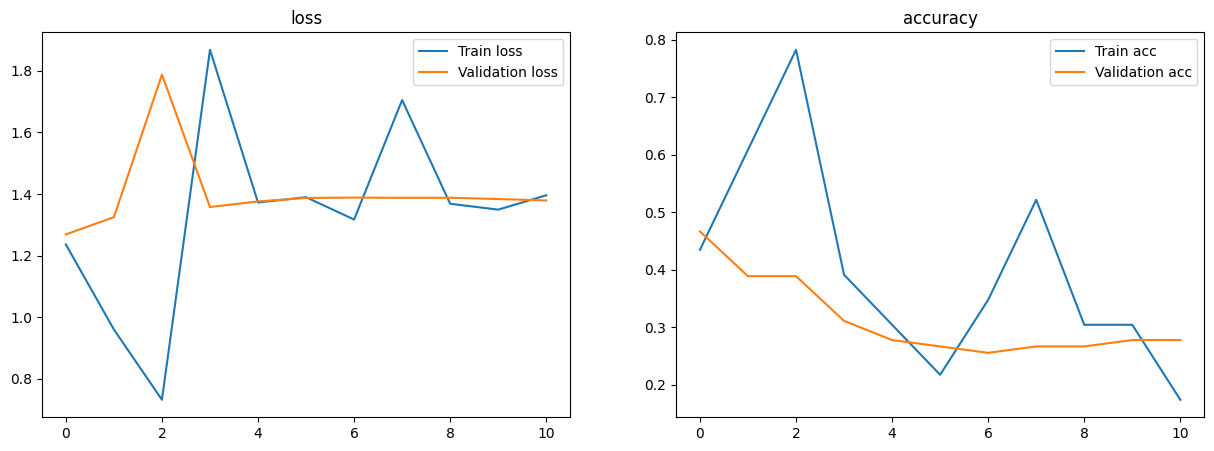

In [96]:
plot_history(history)

In [97]:
plot_history(history_cnn_complexe)

NameError: name 'history_cnn_complexe' is not defined

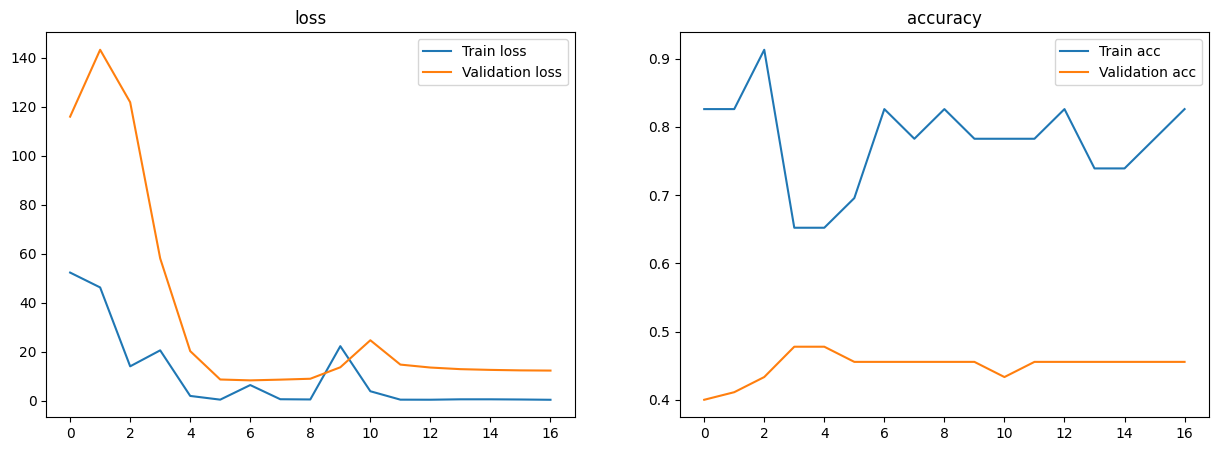

In [98]:
plot_history(history_inception)

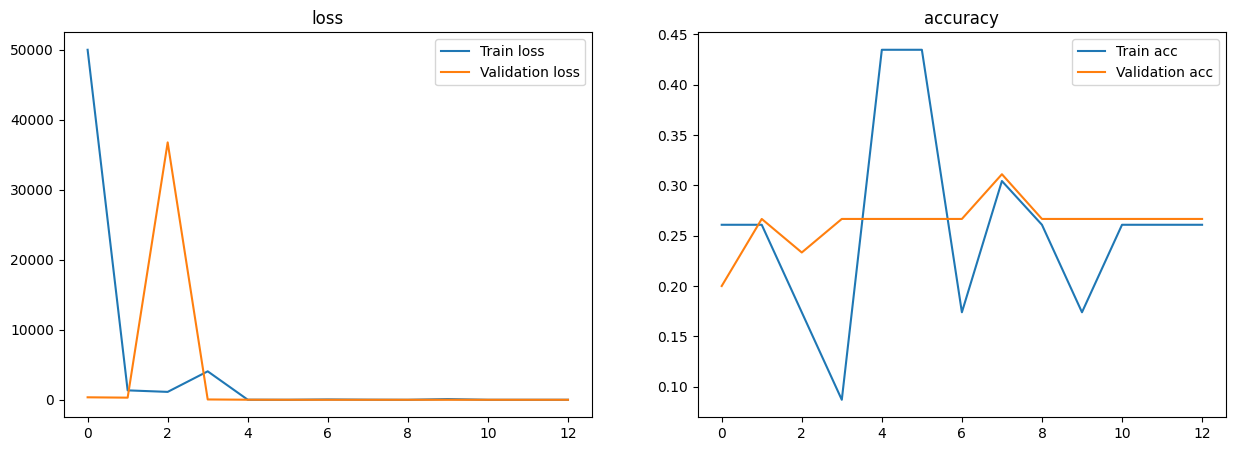

In [99]:
plot_history(history_vgg19)

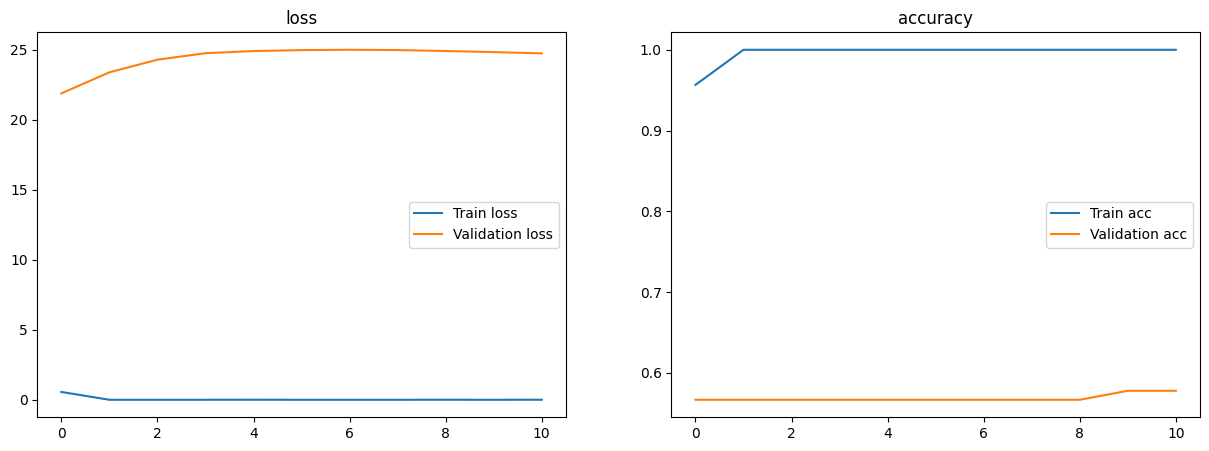

In [100]:
plot_history(history_xception)

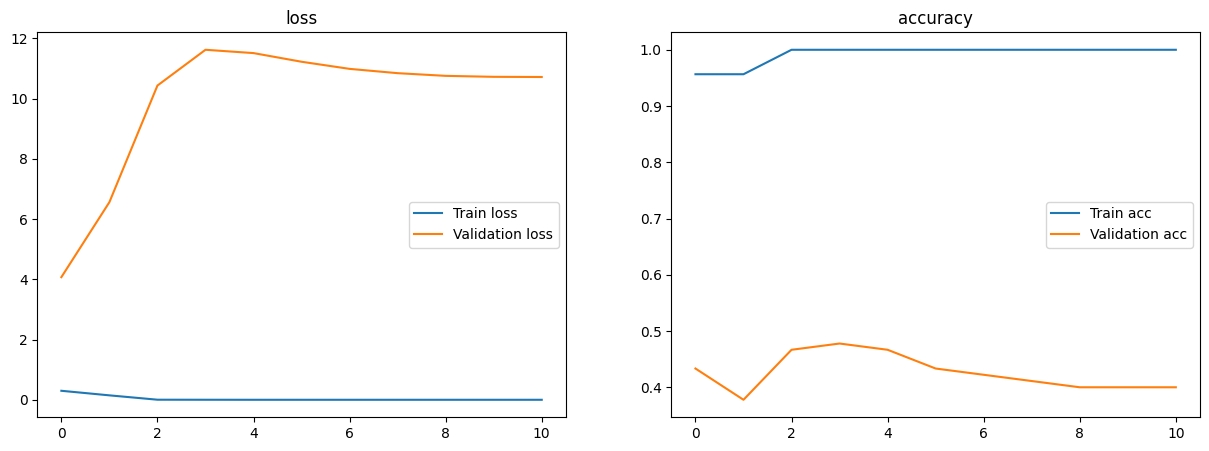

In [101]:
plot_history(history_cnn_simple)

In [11]:
MODEL = "model_1"

modelCheckpoint = callbacks.ModelCheckpoint(MODEL,
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        factor=0.1,
                                        patience=3,
                                        verbose=1,
                                        min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss',
                                       patience=15,
                                       verbose=0,
                                       restore_best_weights=True)